# Current market estimates                                                       
                                                                                  
- UNDER CONSTRUCTION                                                              
                                                                                  
Terence Lim                                                                       
License: MIT                                                                      

In [8]:
from settings import settings
import os
import glob
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay, Weekly
from finds.structured import PSTAT, CRSP, IBES, Benchmarks
from finds.structured import famafrench_sorts, chunk_signal, chunk_stocks
from finds.backtesting import DailyPerformance
from finds.readers import fetch_FamaFrench
from finds.display import plot_date
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
rdb = Redis(**settings['redis'])
imgdir = os.path.join(settings['images'], 'monitor')

# Real-time updates
"""Monthly: update busdays and Fama-French research factors                       
bd = BusDay(sql, create=False)    # create=True to update busdays                 
                                                                                  
bd = BusDay(sql)                                                                  
bench = Benchmarks(sql, bd)                                                       
datasets = fetch_FamaFrench()                                                     
print("\n".join(f"[{i}] {d}" for i, d in enumerate(datasets)))                    
for name, item, suffix in datasets:                                               
    df = fetch_FamaFrench(name=name, item=item, suffix=suffix,                    
                          index_formatter=bd.offset)                              
    for col in df.columns:                                                        
        bench.load_series(df[col], name=name, item=item)                          
print(DataFrame(**sql.run('select * from ' + bench['ident'].key)))                
"""

"""Weekly: price update and clear affected redis store                            
run yahoo                                                                         
./redis-cli --scan --pattern '*CRSP_2021*' | xargs ./redis-cli del                
"""

LAST_DATE = 20210618   # last date in daily prices table                          
bd = BusDay(sql)
bench = Benchmarks(sql, bd)
crsp = CRSP(sql, bd, rdb)
pstat = PSTAT(sql, bd)


## Rebalance and return dates, and initialize classes for calculations            


In [9]:
rebalbeg = bd.offset(20190630)
rebals = [bd.offset(d) for d in [20200630]]
stocks = chunk_stocks(crsp, rebalbeg, LAST_DATE)
perf = DailyPerformance(stocks)

# Compute HML factor 

In [10]:
label = 'hml'
lag = 6               # number of months to lag fundamental data                  
df = pstat.get_linked(  # retrieve required fields from compustat                 
    dataset = 'annual', date_field = 'datadate',
    fields = ['seq', 'pstk', 'pstkrv', 'pstkl', 'txditc'],
    where = (f"indfmt = 'INDL' AND datafmt = 'STD' AND curcd = 'USD' "
             f"  AND popsrc = 'D' AND consol = 'C' "
             f"  AND seq > 0 AND datadate >= 20141201"))

## subtract preferred stock, add back deferred investment tax credit              
df[label] = np.where(df['pstkrv'].isna(), df['pstkl'], df['pstkrv'])
df[label] = np.where(df[label].isna(), df['pstk'], df[label])
df[label] = np.where(df[label].isna(), 0, df[label])
df[label] = df['seq'] + df['txditc'].fillna(0) - df[label]
df.dropna(subset = [label], inplace=True)
df = df[df[label] > 0][['permno', 'gvkey','datadate',label]]

## years in Compustat                                                             
df = df.sort_values(by=['gvkey','datadate'])
df['count'] = df.groupby(['gvkey']).cumcount()

## construct b/m ratio                                                            
df['rebaldate'] = 0
for datadate in sorted(df['datadate'].unique()):
    f = df['datadate'].eq(datadate)
    df.loc[f, 'rebaldate'] = crsp.bd.endmo(datadate, abs(lag)) # 6 month lag      
    df.loc[f, 'cap'] = crsp.get_cap(crsp.bd.endyr(datadate))\
                               .reindex(df.loc[f, 'permno']).values # Dec mktcap  
df[label] /= df['cap']
df = df[df[label].gt(0) & df['count'].gt(1)]         # 2+ years in Compustat      

## compute HML portfolio holdings                                                 
signals = chunk_signal(df)
holdings = famafrench_sorts(crsp, 'hml', signals, rebalbeg, LAST_DATE,
                            window=12, months=[6], rebals=rebals)['holdings']


# Compute MOM momentum factor  

In [12]:
label = 'mom'
past = (2, 12)
df = []      # collect each month's momentum signal values                        
rebalend = bd.endmo(LAST_DATE, -1)
for rebaldate in bd.date_range(rebalbeg, rebalend, 'endmo'):
    beg = bd.endmo(rebaldate, -past[1])   # require price at this date            
    start = bd.offset(beg, 1)             # start date, inclusive, of signal      
    end = bd.endmo(rebaldate, 1-past[0])  # end date of signal                    
    p = [crsp.get_universe(rebaldate),    # retrieve prices and construct signal  
         crsp.get_ret(start, end)['ret'].rename(label),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
    q['rebaldate'] = rebaldate
    df.append(q[['permno', 'rebaldate', label]])
df = pd.concat(df)
signals = chunk_signal(df)
holdings[label] = famafrench_sorts(crsp, label, signals, rebalbeg, rebalend,
                                   window=0, months=[])['holdings'][label]


# Compute and display returns for all factors                                     


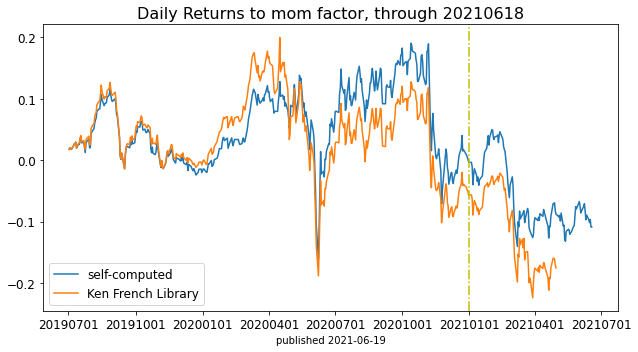

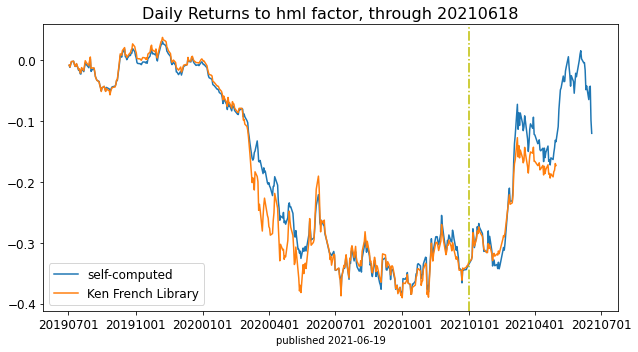

In [14]:
ret = {label: perf(holdings[label], LAST_DATE) for label in holdings.keys()}

## display returns vs bench                                                       
from datetime import datetime
bench = Benchmarks(sql, bd)
ports = {'mom': 'Mom', 'hml':'HML'}
for num, (label, benchname) in enumerate(ports.items()):
    benchret = bench.get_series([benchname], 'ret', start=min(ret[label].index),
                                end=max(ret[label].index))
    fig, ax = plt.subplots(num=1+num, figsize=(9, 5), clear=True)
    plot_date(y1=ret[label].cumsum().to_frame().join(benchret.cumsum()),
              ax=ax, legend1=['self-computed', 'Ken French Library'],
              loc1='lower left', vlines=[20201231],
              title=f"Daily Returns to {label} factor, through {LAST_DATE}")
    ax.set_xlabel(f"published {datetime.now().strftime('%Y-%m-%d')}")
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, f"{label}.jpg"))
plt.show()


In [ ]:
"""                                                                               
real-time forecasts                                                               
- weekly reversal - decomposition                                                 
  - SP500 ETF vol                                                                 
  - VIX ETF                                                                       
ETFs                                                                              
factor returns                                                                    
conditional vol                                                                   
nowcast                                                                           
"""